In [1]:
1+1

2

In [2]:
!pip install segmentation_models_pytorch
import os
import numpy as np
from PIL import Image, ImageFilter, ImageDraw
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import albumentations as A  
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import random
import torchvision.transforms.functional as TF
import segmentation_models_pytorch as smp
from IPython.display import clear_output
import cv2
from torchvision import transforms
import copy

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import time
import math

clear_output() 

In [3]:
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

LEARNING_RATE = 3e-4
BATCH_SIZE    = 4 # 64
NUM_EPOCHS    = 10

IMAGE_HEIGHT  = 384  
IMAGE_WIDTH   = 384

MODEL_PATH = '/kaggle/working/model_jew_mask_02.05.2023.md'

INPUT_TRANSPARENT_DIR = '/kaggle/input/jewellery/raw_data_all/raw_data_all'
# IMAGE_DIR = '/kaggle/working/images/'
# MASK_DIR = '/kaggle/working/masks/'

REAL_PATH = '/kaggle/input/house-rooms-streets-image-dataset/kaggle_room_street_data/house_data'
ROCK_PAPER_SCISSORS_PATH = '/kaggle/input/rock-paper-scissors-dataset/train'
AAA_PATH  = '/kaggle/input/jewellery/aaa-jewellery-images/aaa-jewellery-images'

K_RATIO = 2

cuda


In [5]:
def load_model_detection(name):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)    
    
    num_classes = 2  # 1 class (wheat) + background
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    if torch.cuda.is_available():
        model.load_state_dict(torch.load(name))
    else:    
        model.load_state_dict(torch.load(name, map_location=torch.device('cpu')))
      
    model.to(DEVICE)
    return model

In [6]:
def load_model_mask(name):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    
    in_features = model.roi_heads.box_predictor.cls_score.in_features 
    model.roi_heads.box_predictor=FastRCNNPredictor(in_features,num_classes=2)
    
    if torch.cuda.is_available():
        model.load_state_dict(torch.load(name))
    else:    
        model.load_state_dict(torch.load(name, map_location=torch.device('cpu')))
        
    params = [p for p in model.parameters() if p.requires_grad]        
   
    model.to(DEVICE)

    return model

In [7]:
model_detection = load_model_detection('/kaggle/input/jewellery/models/model_jew_detect_01.05.2023.md')
model_mask = load_model_mask('/kaggle/input/jewellery/models/model_jew_mask_13.05.2023v2.md')
clear_output() 

In [8]:
model_detection.eval()
model_mask.eval()
print()

In [9]:
def draw_box_on_image(image, x0, y0, x1, y1, color='green'):
    show_box = copy.copy(image)
    draw=ImageDraw.Draw(show_box)
    draw.rectangle([(x0, y0),(x1, y1)],outline=color, width=3)
    return show_box    

In [10]:
def draw_box_on_image_multi(image, xy, color='green'):
    show_box = copy.copy(image)
    draw=ImageDraw.Draw(show_box)
    
    for data in xy:
        x0, y0, x1, y1 = data[0],data[1],data[2],data[3]
        
        draw.rectangle([(x0, y0),(x1, y1)],outline=color, width=3)
    return show_box  

In [11]:
def get_random_images(dir_images, n=2):
    images_in_dir = os.listdir(dir_images)    
    image_names = random.sample(images_in_dir, n)
    
    image_list = []
    
    for name in image_names:
        img_path_image = os.path.join(dir_images, name)   
        image = Image.open(img_path_image)
        image_list.append(image)
    return image_list      

In [12]:
def PIL_image_to_tensor(image, model_shape):
    test_transform = torch.nn.Sequential(    
        transforms.Resize(model_shape),    
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),        
        )       
    
    image = TF.to_tensor(image)    
    image = test_transform(image)
    return image  
    
    
def PIL_images_to_tensors(images, model_shape):
    images = [i.convert('RGB') for i in images]
    return [PIL_image_to_tensor(i, model_shape=model_shape) for i in images]   

In [13]:
def jewellery_detection_get_rx_ry(images, model, model_shape=(384, 384), k=0):
    '''
    Делает детекцию объектов. Выдает относительные координаты
    :param images: список PIL Image изображения - желательно делать маленькими батчами
    :param model: model for detection
    :param model_shape: shape of images in model
    :return" relative coordinates (i.e. coordinate devide dimenstion of image) of detection box in a format (x1, y1, x2, y1)
    '''
    model.eval()   
    
    aug_image = PIL_images_to_tensors(images, model_shape=model_shape)
    aug_image = list(image.to(DEVICE) for image in aug_image)    
    model.to(DEVICE)
    predictions = model(aug_image)
    
    result =[]
    
    
    for i, prediction in enumerate(predictions):    
    
        pred_boxs = prediction['boxes']
        pred_boxs_numpy = pred_boxs.detach().cpu().numpy()
        
        pred_scores = prediction['scores']
        pred_score = pred_scores[0].item()

        pred_scores_numpy = pred_scores.detach().cpu().numpy()

        
        for threshold in [0.8, 0.7, 0.6, 0.5]:
            list_ind = np.where(pred_scores_numpy > 0.8)[0]
            ind_max = len(list_ind)
            if ind_max > 0:
                break
        if ind_max == 0:
            ind_max = 1

        pred_boxs_good = pred_boxs_numpy[:ind_max]

        best_x1 = min([p[0] for p in pred_boxs_good])
        best_y1 = min([p[1] for p in pred_boxs_good])
        best_x2 = max([p[2] for p in pred_boxs_good])
        best_y2 = max([p[3] for p in pred_boxs_good])    

        rx1 = best_x1 / model_shape[0]
        ry1 = best_y1 / model_shape[1]
        rx2 = best_x2 / model_shape[0]
        ry2 = best_y2 / model_shape[1]   

        if k > 0:
            rx1 = max(rx1 - k, 0)
            rx2 = min(rx2 + k, 1)        
            ry1 = max(ry1 - k, 0)
            ry2 = min(ry2 + k, 1)

        result.append(((rx1, ry1, rx2, ry2), pred_score))
        
    return result  

In [34]:
images_original = get_random_images('/kaggle/input/jewellery/aaa-jewellery-images/aaa-jewellery-images', n=4)

In [35]:
rboxes = jewellery_detection_get_rx_ry(images_original, model_detection, k=0.02)    

In [36]:
def crop_image(image, rbox):
    image_shape = image.size      
    x1 = image_shape[0] * rbox[0]
    y1 = image_shape[1] * rbox[1]
    x2 = image_shape[0] * rbox[2]
    y2 = image_shape[1] * rbox[3]     
    return image.crop((x1, y1, x2, y2))

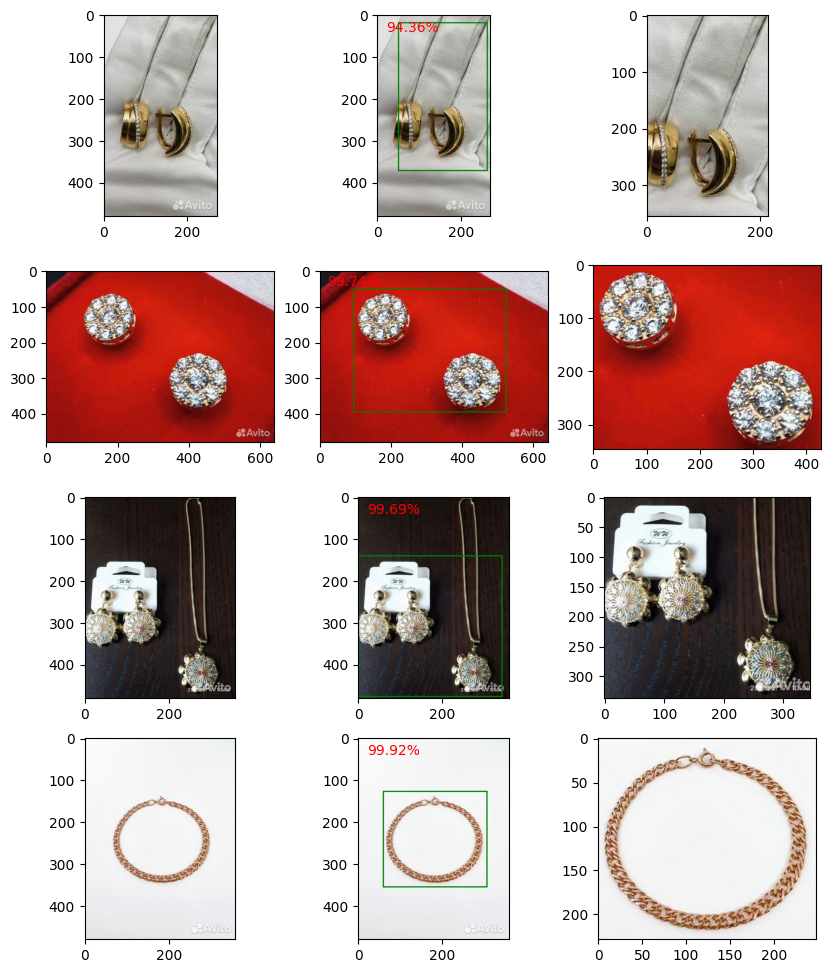

In [37]:
rows = len(rboxes)
_, ax = plt.subplots(rows, 3, figsize=(10,3*rows))

for k in range(rows):
    ax[k][0].imshow(images_original[k])      
    
    rbox, acc = rboxes[k]
    image_shape = images_original[k].size   
    
    x1 = image_shape[0] * rbox[0]
    y1 = image_shape[1] * rbox[1]
    x2 = image_shape[0] * rbox[2]
    y2 = image_shape[1] * rbox[3]
    
    image_with_box = draw_box_on_image(images_original[k], x1, y1, x2, y2, color='green')        
        
    ax[k][1].imshow(image_with_box)    
    ax[k][1].text(20,40, f'{acc:.2%}', color='red')

    ax[k][2].imshow( crop_image(images_original[k], rbox) )    

In [38]:
def jewellery_mask(images, model, model_shape=(384, 384), k=0):
    transform = transforms.ToPILImage()
    
    model.eval()   
    
    aug_image = PIL_images_to_tensors(images, model_shape=model_shape)
    aug_image = list(image.to(DEVICE) for image in aug_image)    
    model.to(DEVICE)
    predictions = model(aug_image)
    
    result =[]   
    
    for i, prediction in enumerate(predictions):           

        pred_box = prediction['boxes'][0].tolist()
        pred_score = prediction['scores'][0].item()
        pred_mask = transform(prediction['masks'][0])        
        
        result.append((pred_mask, pred_score))
    return result   

In [39]:
masks = jewellery_mask(images_original, model_mask)    

In [40]:
def clean_image_with_mask(image, r=0.6):
    if r == None:
        return image
    
    image = np.array(image)
    
    x = image[:,:,3] / 255.0+(r-0.5)
    x = np.clip(x, 0, 1)    
    image[:,:,3] = x.round()*255
    
    return Image.fromarray(image)

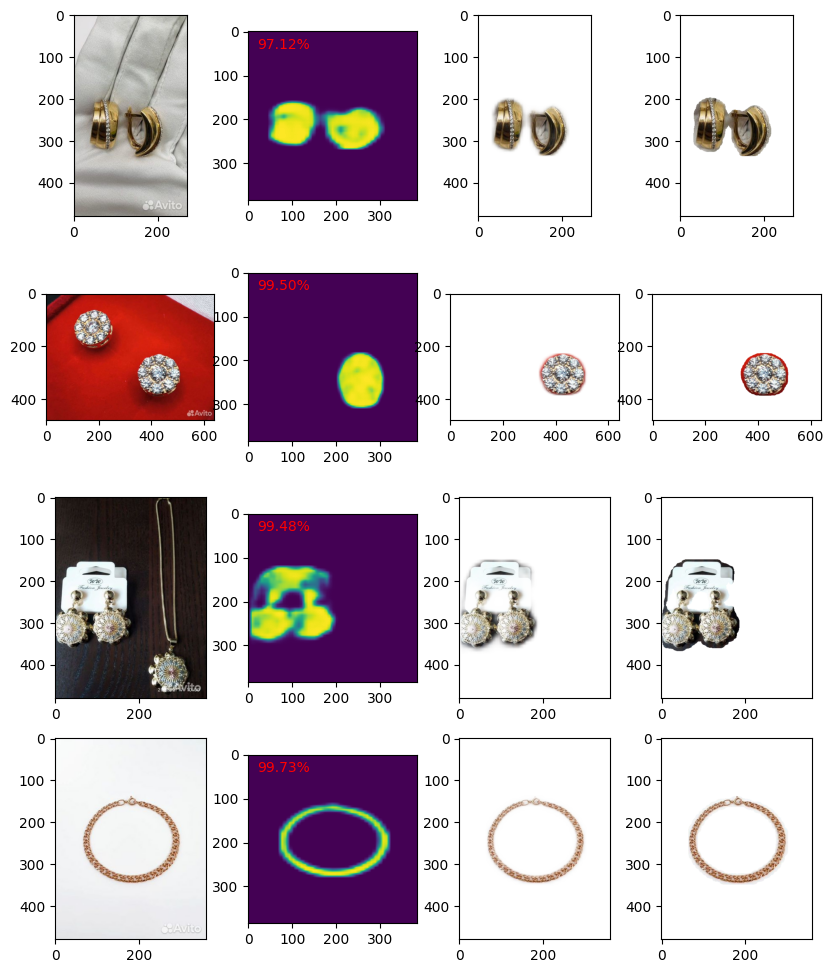

In [41]:
rows = len(masks)
_, ax = plt.subplots(rows, 4, figsize=(10,3*rows))

for k in range(rows):
    ax[k][0].imshow(images_original[k])      
    
    mask, acc = masks[k]

    ax[k][1].imshow(mask)    
    ax[k][1].text(20,40, f'{acc:.2%}', color='red')
    
    q = copy.copy(images_original[k])
    q.putalpha(mask.resize(images_original[k].size)  )
    
    ax[k][2].imshow(q)
    
    
    
    q_clean = clean_image_with_mask(q, r=0.9)       
    ax[k][3].imshow(q_clean)

In [42]:
def jewellery_detect_crop_mask(images, model_detection, model_mask, model_shape=(384, 384), k=0):
    
    rboxes = jewellery_detection_get_rx_ry(images, model_detection, model_shape=model_shape, k=0.02)   
   
    cropped_images = []
    detect_acc = []

    rows = len(rboxes)    
    for k in range(rows):    
        rbox, acc = rboxes[k]
        cropped_image = crop_image(images_original[k], rbox)
        cropped_images.append(cropped_image)
        detect_acc.append(acc)
            
    masks = jewellery_mask(cropped_images, model_mask)    
    
    result = []
    for k in range(rows):    
        res = {}
        res['cropped_image'] = cropped_images[k]
        res['detection_accurancy'] = detect_acc[k]
        res['mask'] = masks[k][0]
        res['segmentation_accurancy'] = masks[k][1]
        
        result.append(res)        
    
    return result

In [43]:
res = jewellery_detect_crop_mask(images_original, model_detection, model_mask)

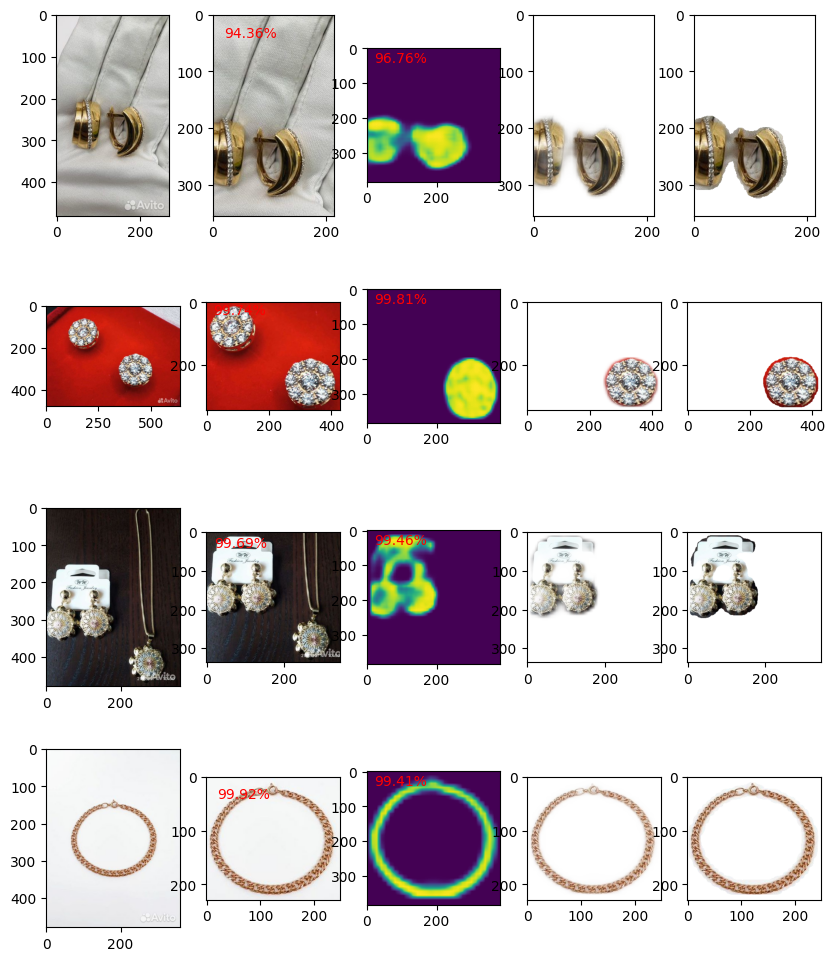

In [44]:
rows = len(res)
_, ax = plt.subplots(rows, 5, figsize=(10,3*rows))

for k in range(rows):
    ax[k][0].imshow(images_original[k])      
    
    cropped_image = res[k]['cropped_image']
    cropped_image_acc = res[k]['detection_accurancy']    
    ax[k][1].imshow(cropped_image)      
    ax[k][1].text(20,40, f'{cropped_image_acc:.2%}', color='red')

    
    mask = res[k]['mask']
    acc = res[k]['segmentation_accurancy']

    ax[k][2].imshow(mask)    
    ax[k][2].text(20,40, f'{acc:.2%}', color='red')
    
    q = copy.copy(cropped_image)
    q.putalpha(mask.resize(cropped_image.size)  )    # !!!!
    ax[k][3].imshow(q)   
        
    q_clean = clean_image_with_mask(q, r=0.9)       
    ax[k][4].imshow(q_clean) 

In [45]:
def get_jewellery_image(images_original, model_detection, model_mask, 
                        model_shape=(384, 384), 
                        k=0.05, 
                        threshold_detect=0.98, 
                        threshold_segmentation=0.99,
                        threshold_clean_mask = 0.9,
                        show_bad_results=True,
                       ):
    
    predict = jewellery_detect_crop_mask(images_original, model_detection, model_mask, model_shape=(384, 384), k=k)
    rows = len(res)
    
    for k in range(rows):
        ax[k][0].imshow(images_original[k])      

        cropped_image = predict[k]['cropped_image']
        cropped_image_acc = predict[k]['detection_accurancy']    

        mask = res[k]['mask']
        acc = res[k]['segmentation_accurancy']

        q = copy.copy(cropped_image)
        q.putalpha(mask.resize(cropped_image.size)  )    
        q_clean = clean_image_with_mask(q, r=threshold_clean_mask)       
        predict[k]['image_segmented'] = q_clean
        
        if predict[k]['detection_accurancy'] < threshold_detect and not show_bad_results:
            predict[k]['cropped_image'] = None
            
        if predict[k]['segmentation_accurancy'] < threshold_detect and not show_bad_results:
            predict[k]['image_segmented'] = None  
            
        predict[k]['image_original'] = images_original[k]  
        
    return predict

In [46]:
res = get_jewellery_image(images_original, model_detection, model_mask, 
                        k=0.05, 
                        threshold_detect=0.9, 
                        threshold_segmentation=0.99,
                        threshold_clean_mask = 0.9,
                        show_bad_results=False,
                       )

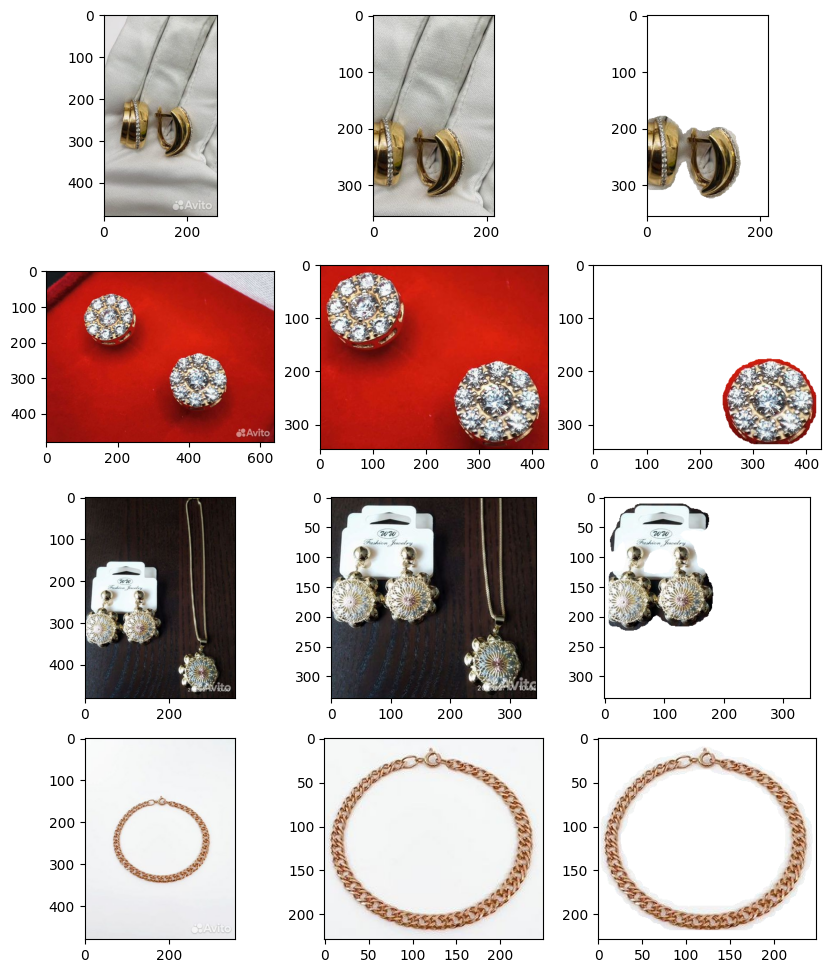

In [47]:
rows = len(res)
_, ax = plt.subplots(rows, 3, figsize=(10,3*rows))

for k in range(rows):
    ax[k][0].imshow(res[k]['image_original'])      
    
    if res[k]['cropped_image'] is not None:
        ax[k][1].imshow(res[k]['cropped_image']) 
    
    if res[k]['image_segmented'] is not None:
        ax[k][2].imshow(res[k]['image_segmented'])   

In [48]:
images_original = get_random_images('/kaggle/input/jewellery/aaa-jewellery-images/aaa-jewellery-images', n=4)